# 0. ABSTRACT

대기 시간과 정확성을 효율적으로 상호 조정하는 두 가지 간단한 글로벌 하이퍼파라미터를 통해 모델은 문제의 제약 조건에 따라 애플리케이션에 적합한 크기의 모델을 선택한다. MobileNets는 depthwise separable convolutions를 사용하여 경량 심층 신경 네트워크를 구축하는 간소화된 아키텍쳐를 기반으로 한다.  
이는 ImageNet 분류에서 우수한 성능을 보였고 Object Detection, Segmentation classification 등 광범위한 애플리케이션과 사용 사례에서 MobileNets의 효과를 시연한다.

# 1. Introduction

MoblieNet는 mobile이나 embedded vision(ex : 증강현실)에서 사용되기 위해 개발된 모델로서, 이전까지 대부분의 연구가 모델의 performance에 초점을 맞추어 모델을 깊고 넓게, 복잡하게 설계한 반면, MoblieNets은 모델의 경량화가 최우선이였다.  

해당 논문에서는 효율적인 network architecture를 제안하고, 두 가지 하이퍼 파라미터 set을 통해 모델을 쉽게 요규되는 사양에 따라 작게 만들 수 있도록 했다.

# 2. Prior Work

해당 section에서는 Efficient Net의 목적처럼 모델을 줄이기 위한 다양한 related work에 대해서 소개한다.

작고 효율적인 모델을 만드는 것에 대한 관심이 이 당시에 많은 관심사를 끄는 영역이었다.
위 문제에 대해서 다른 많은 연구들은 pretrained network를 '압축' 하거나 '작은' network를 training시키는 방식으로 진행되었다.
MobileNet은 후자에 가깝지만, 개발자가 요구하는 mobile or embedded system의 사양에 따라 network(latency, size,,, 등)를 자유자재로 조절할 수 있다는 점에서 차별점을 가진다.

이후에는 MobilNet에서 중요한 역할을 하는 depth-wise separable network를 사용한 논문에 대한 간략한 소개 및 다양한 모델 경량화 방법(quantization, pruning, hashing, distillation 등)에 대한 언급이 있다.

# 3. Mobile Net Architecture

## 3.1. Depthwise Separable Convolution

MobileNet은 `depthwise separabel convolution` 연산에 기반을 둔 network 이다. depthwise separabel convolution은 기존 convolution 연산을 depthwise convolution과 1x1 convolution(pointwise convolution), 2가지 과정으로 분해함으로써 연산량을 줄이고 모델의 크기 또한 줄일 수 있다.  

간단히 정리하면 `depthwise separabel convolution` = `depthwise convolution` + `1x1 convolution`이다.  

자세히 알아보기 위해 `standard convolution`부터 알아보자  

__< 용어 정리 >__  
* $D_F$ : spatial width and height of input   
* $M$ : input channel  
* $D_K$ : spatial width and height of kernel
* $N$ : kernel channel

### Standard Convolution

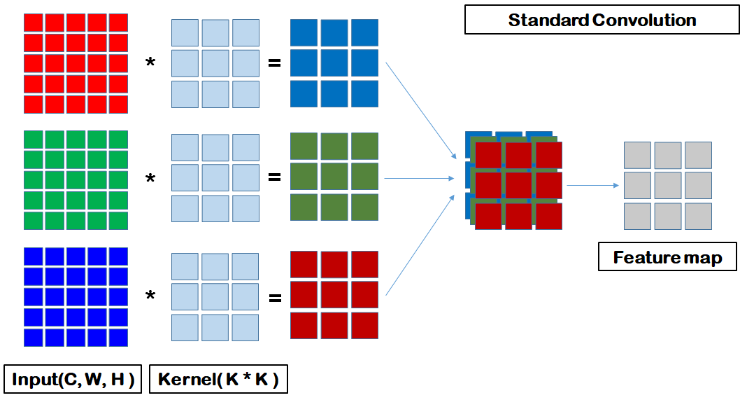

`standard convolution`은 우리가 기존에 알던 CNN의 convolution 연산을 말하며 kernel과 input을 결합하여 새로운 output을 산출하는 과정을 한번에 진행한다.  

그림을 보며 이해해보자. shape이 (5,5,3)의 이미지가 input으로 들어왔다고 가정하자. kernel의 shape은 (3,3,3,1) 이다.(padding 적용, stride = 1)  
그럼 input의 각 채널별로 하나의 필터가 window sliding을 통해 3개($M$)의 output을 만든다. 그 후 1개의 channel로 병합되어 최종 feature map으로 출력된다.  

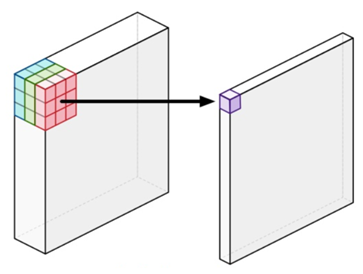

이 과정에서 kernel의 크기는 $D_K$, input의 channel수는 $M$이다. 따라서 하나의 kernel이 가지는 크기는 $D_KD_KN$임을 알 수 있다. 하나의 kernel에서 나오는 output은 하나의 channel에 해당하기 때문에, output을 $N$개의 channel로 만들어주려면 이러한 kernel의 개수가 총 $N$개 있어야 한다. 따라서 총 param의 수는 $D_KD_KNM$개가 된다.  

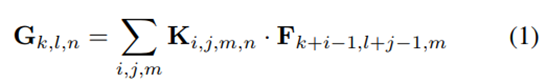

standard convolution에 대한 출력 feature map은 위와 같이 계산되고 최종 연산량은 param 수에 input의 size를 곱한  

$$D_KD_KNMD_FD_F$$  

가 된다.  

standard convolution 연산은 새로운 representation을 생성하기 위해 convolution kernel을 기반으로 feature를 필터링하고 feature를 결합하는 효과가 있다. 필터링 및 결합 단계는 계산 비용의 상당한 절감을 위해 `depthwise separable convolutions`라고 하는 인수 분해된 convolution을 사용하여 두 단계로 분리할 수 있다.

### Depth-wise Convolution

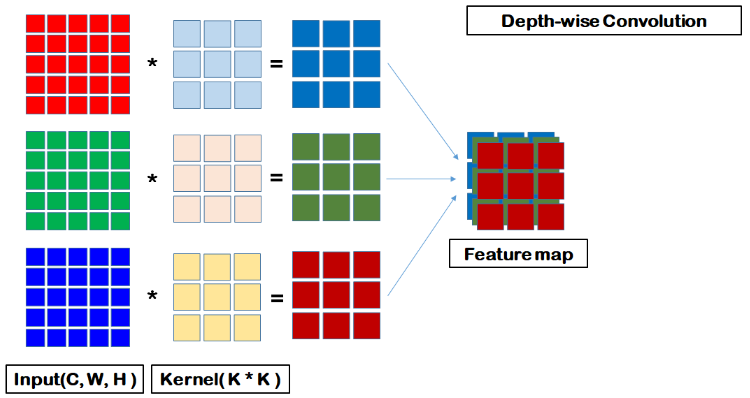  


`depth-wise convolution`과 standard convolution의 차이점은 마지막 convolution하여 나온 channel 별 feature map을 병합하지 않는다는 것이다.  

standard convolution가 한번에 filtering과 combining을 진행한 것과 달리, depth-wise convolution에서는 filtering만 진행한다. input의 channel마다 각각 filtering을 거치고, 그 결과를 단순히 concat한다.  

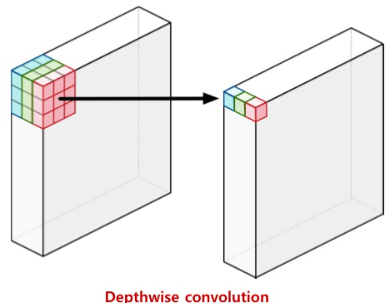

standard convolution에서는 kernel은 모든 채널을 사용하여 연산을 진행하기 때문에 특정 채널의 spatial(공간) feature만을 추출하지 못한다. 반면에 depth-wise convolution은 input의 channel에 각각 독립적으로 대응되는 kernel을 사용한다. 위의 그림을 예시로 하면 input (5,5,3)이 입력으로 들어오면 input의 각 channel에 대해서 kernel을 적용하여 convolution을 진행하고, 출력된 output을 channel 방향으로 concat하여 최종 activation map을 출력한다. 결국, kernel이 특정 채널의 spatial feature를 학습할 수 있게 되었다고 할 수 있다.  

`depth-wise convolution`의 연산은 최종 output channel수 만큼 곱하지 않아도 되기 때문에  

$$D_KD_KND_FD_F$$  

($N, M$ 둘 다 사용 가능, input과 output의 channel이 같기 때문)이다.

###  Separable convolution(Point-wise conv, 1x1 conv)

앞서 위에서 convolution param의 수를 구해보았다.  
이를 공식화하면 __Convolution Parameters = Kernel Size x Kernel Size x Input Channel x Output Channel__ 로 표현할 수 있다. `1x1 convolution`에 대해 알아보기 전에 CNN의 __`BottleNeck`__ 구조를 알아보자.  

#### Bottel Neck

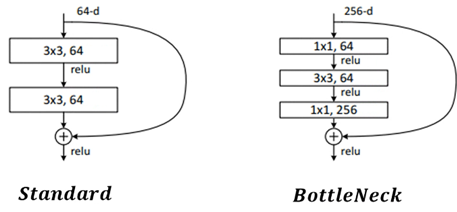  

대표적으로 `ResNet`에서 BottelNeck을 사용했다.  
ResNet에서 왼쪽은 BottelNeck 구조를 사용하지 않았고, 오른쪽은 BottelNeck 구조를 사용했다. BottelNeck의 핵심은 __1x1 Convolution__ 이다. 1x1 convolution의 parameters는 __1x1xInput Channel x Output Channel__ 이다. 일반적으로 1x1 convolution은 연산량이 작기 때문에 feature map(output channel)을 줄이거나 키울 때 사용된다. 아래의 그림으로 구조를 살펴보자.  

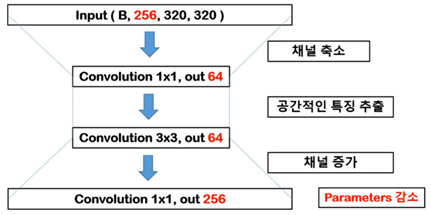  

input이 (256,320,320)인 Image가 있다고 가정하자. 이 input의 channel을 256에서 64로 줄인 이유는 오로지 연산량을 줄이기 위함이다. 1x1 convolution에는 spatial 특징을 가지고 있지 않다. convolution 연산이 spatial 특징을 추출하기 위해선 kernel이 최소 2 이상이 되어야 한다. 따라서 채널을 줄이면서 줄어든 연산량을 바탕으로 spatial 특징을 추출하기 위해 3x3 convolution을 진행한다. 그 후에 원래의 채널인 256으로 1x1 convolution을 통해 연산량을 최소화한다.  
__즉, 쉽게 말해 BottelNeck은 1x1 convolution을 적재적소에 넣어 연산량을 강제로 줄이고자 함에 특화되어 있다.__  

연산량이 줄어든다는 획기적인 아이디어지만, 물론 단점도 존재한다. 강제로 채널을 줄이고 늘리는 것은 당연하겠지만 정보 손실을 일으킨다. 정보 손실은 곧 모델의 정확성과 연관되어 있다. 연산량과 정보손실은 곧 trade-off 관계이기 때문에 서로의 합의점을 찾는 것이 중요하다고 할 수 있다.  

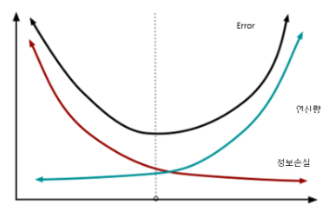

다시 본론으로 돌아가 `depth-wise convolution`은 standard convolution에 비해서 연산이 효율적이지만, filtering만 가능할 뿐, 새로운 feature를 만들 수 없다. 따라서 depth-wise convolution의 output의 선형 결합을 만들어내기 위해서 사용되는 `1x1 convolution`을 통해 channel 방향의 combining을 수행하여 새로운 feature map을 생성한다.  

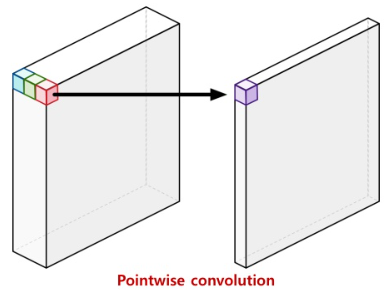  

`1x1 convolution`의 연산은 kernel size = 1 이기 때문에  

$$NMD_FD_F$$  

이다.

### Depth-wise Separable Convolution

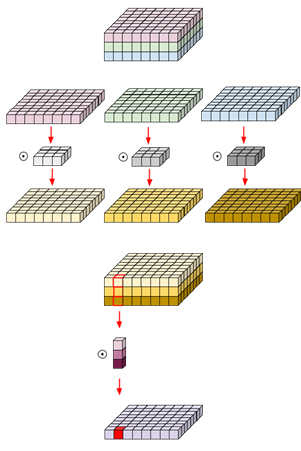

앞서 설명한 depth-wise convolution 과 1x1 convolution을 결합한 것이 바로 __`depth-wise separable convolution`__ 이다. 위 그림은 해당 연산과정을 표현하고 있다.  

depth-wise convolution을 사용하여 각 입력 채널당 하나의 필터(input depth)를 적용한다. 그런 다음 depth-wise의 layer에 대한 선형 조합을 만드는데 간단한 1x1 convolution을 사용한다. MobileNet은 두 레이어에 BatchNorm과 ReLU를 사용한다.  

depth-wise separable convolution 연산량은 위의 두 레이어의 연산량을 더한 다음과 같다.  

$$D_KD_KND_FD_F + M N D_F D_F$$   

연산량을 통해서도 알 수 있듯, depth-wise convolution 과 1x1 convolution의 합이 곧 depth-wise separable convolution이며 __`MoblieNet`__ 의 핵심 아이디어 이다.

depth-wise separable convolution의 연산량을 standard convolution으로 나누면 $\frac{D_KD_KND_FD_F + M N D_F D_F}{D_KD_KNMD_FD_F}$ 이고 이를 계산하면 $\frac{1}{N} + \frac{1}{{D_K}^2}$가 된다. 결국 MobileNet은 model architecture에서 standard convolution을 depth-wise convolution으로 일부 대체하면서 $\frac{1}{N} + \frac{1}{{D_K}^2}$ 만큼의 연산량을 줄일 수 있게 되었다.  
추가로 MobileNet은 3x3 depth-wise separable convolution을 사용한다. 이는 standard convolution 보다 8~9배의 적은 연산량을 필요로 한다.

## 3.2. Network Structure and Training

MobileNet 구조는 fully convolution인 첫 번째 layer를 제외하고 이전 섹션에서 언급한 것 처럼 depth-wise separable convolution을 기반으로 구축된다. 구조는 __< Table 1 >__ 에 있다. 비선형성이 없고 분류를 위해 softmax layer로 공급되는 FC layer를 제외하고 모든 layer에는 BatchNorm과 ReLU가 적용되는 것을 알 수 있다.

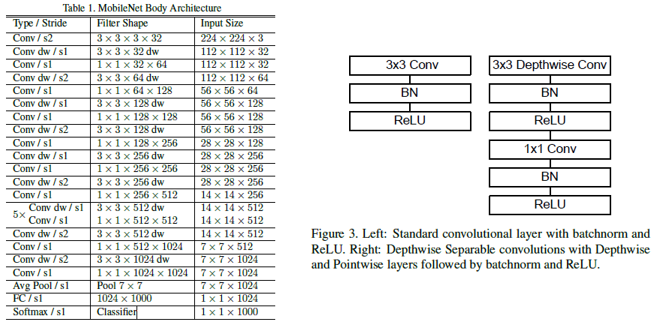

__<Figure 3>__ 은 각각 standard convolution 과 depth-wise separable convolution의 모델 구조를 나타내고 있다. 우측의 depth-wise separable convolution을 보면 위에서 언급한 3x3 depth-wise conv를 거친 후에 BatchNorm, ReLU를 거치고 1x1 conv를 통해 연산량을 줄이고 BatchNorm, ReLU를 거친다. Down-sampling은 depth-wise convolution과 첫 번째 conv layer에서 수행하고 총 28개의 layer를 갖는다. 해당 연산을 반복하여 __< Table 1>__ 의 아키텍쳐로 MobileNet을 구축한다.  

단순히 네트워크를 소수의 Mult-Adds(한 이미지를 인식하는데 필요한 곱셈-합 연산의 수)로 정의하는 것만으로는 충분하지 않고 어느정도의 한계도 존재한다. 또한 이러한 작업을 효율적으로 구현하도록 하는 것도 당연히 중요하다. 예를 들어, 구조화되지 않은 sparse matrix 연산은 일반적으로 매우 높은 sparse 레벨이 될 때 까지 dense matrix 연산보다 빠르지 않다. 따라서 MobileNet에서는 거의 모든 계산을 1x1 convolution으로 만든다.  

이는 고도로 최적화된 __GEMM(General Matrix Multiply)__ 에 의해서 구현될 수 있다. 종종 GEMM에 의해 convolution이 구현되지만, 이를 mapping하기 위해 __im2col__ 이라는 메모리에서 초기 재주문이 필요하다. 하지만 1x1 convolution은 메모리 재정렬을 요구하지 않기 때문에 가장 최적화된 알고리즘 중 하나인 GEMM를 사용하여 직접 구현될 수 있다.   

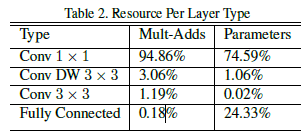  

MobileNet은 계산 시간의 95%를 1x1 convolution 에 소비하며, __< Tabel 1 >__ 에서 볼 수 있듯 전체 파라미터의 75%를 사용한다. 거의 모든 추가 매개변수가 완전히 FC layer에 있다고 보면 된다.  

MobileNet은 TensorFlow에서 학습되었으며, Inception v3에서 사용한 RMSprop이 optimizer로 사용되었다. 큰 모델을 훈련시키는 것과는 달리 MobileNet에서는 over-fittint이 일어날 가능성이 비교적 적기 때문에 regularization, augmentation이 덜 사용되었다.  

추가적으로 연구진들은 DW filter에 파라미터가 매우 적기 때문에 weight decay를 적게 주거나 아예 안주는 것이 중요하다는 것을 알아냈다.  

__< weight decay >__  

Loss function이 작아지는 방향으로만 단순하게 학습을 진행하면 특정 가중치 값들이 커지면서 오히려 결과가 나빠질 수 있다. Weight decay는 학습된 모델의 복잡도를 줄이기 위해서 학습 중 weight가 너무 큰 값을 가지지 않도록 Loss function에 Weight가 커질경우에 대한 패널티 항목을 집어넣는다. 이 패널티 항목으로 많이 쓰이는 것이 L1 Regularization과 L2 Regularization이다. Weight decay 를 적용할 경우  Overfitting에서 벗어날 수 있다.


## 3.3. Width Multiplier: Thiner Models

Network의 Width를 조절할 수 있는 hyperparameter인 Width Multiplier에 대해서 소개한다. MobileNet이 이미 작고, Low latency를 가진 model이지만, 사용자에 따라서 더 작고, 더 빠른 속도가 필요할 수도 있다. 이때 Width Multiplier라고 불리는 hyper parmeter $\alpha$를 사용하여 간단하게 Model을 더 축소시킬 수 있다. $\alpha$의 역할은 균일하게 각 layer를 __얇게__ 만드는 것이다.  

layer와 $\alpha$가 주어졌을 때 input channel $M$은 $M$x$\alpha$가 되고, output channel $N$은 $N$x$\alpha$가 된다. channel에 $\alpha$를 곱해주어서 모델을 자게 만드는 단순한 아이디어이다. 각 channel의 파라미터가 바꼈으니 연산량 또한 당연히 다음과 같이 바뀐다.  

$$D_KD_KN\alpha D_FD_F + M\alpha N\alpha D_F D_F$$  

여기서 $\alpha$는 __1 이하의 값__ 만을 가지며, 1일 때는 basic network와 같다. 일반적으로 1, 0.75, 0.5, 0.25의 값을 가지도록 설정한다. 보통 $\alpha$는 $\alpha^2$ 만큼의 연산량 감소를 기대할 수 있다.

Width Multiplier는 합리적으로 작은 모델을 만들기 위해서 다른 Model에도 적용될 수 있다. 하지만 accuracy와 $\alpha$의 trade-off 가 존재하기 때문에 신중한 결정이 필요하다.

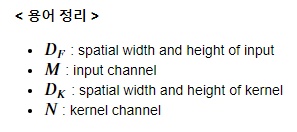

## 3.4. Resolution Multiplier: Reduced Representation

Network의 computational cost를 줄일 수 있는 또 다른 방법인 Resolution Multiplier에 대해서 소개한다. Resolution Multiplier은 $p$로 표현되고, input image 또는 각 layer의 internal representation(activation map)에 $p$ 곱해주어서 연산량을 줄일 수 있도록 하는 hyper parameter이다.  

앞서 설명한 Width Multiplier과 Resolution Multiplier를 적용한 depth-wise separable convolution의 연산량은 다음과 같다.  

$$D_KD_K(N\alpha)(pD_F)(pD_F) + (M\alpha) (N\alpha) (pD_F) (pD_F)$$  

일반적으로 input image의 해상도가 224, 192, 160, 128이 되도록 $p$를 정해주고 $p$는 __1 이하의 값__ 이다. 마찬가지로 $p^2$ 만큼의 연산량 감소를 기대할 수 있다.  

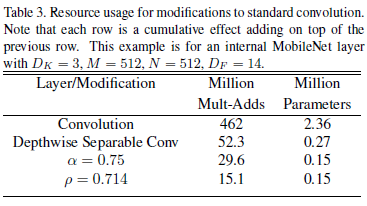

# 4. Experiments

연구진들이 Network의 layer 수를 줄이는 것 대비 depth-wise separable convolution을 사용하거나 위에서 소개한 multiplier를 사용했을 때 어느정도 효과가 있는지 조사한 결과를 살펴본다. 그리고 여러 유명한 model들과 비교하면서 Width Multiplier, Resolution Multiplier를 사용하면 어느정도의 trade off가 생기는지도 알아본다.

## 4.1. Model Choices

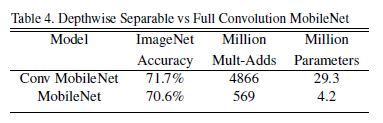  

__< Table 4 >__ 를 살펴보면 MobileNet architecture를 모두 standard convolution으로 구성했을 때 대비 depthwise separable convolution을 섞은 MobileNet이 Mult-Adds는 크게 줄었지만,
accuracy는 약 1% 정도만 손해를 본 결과를 확인할 수 있다.

이는 MobileNet의 Mobile이나 Embedded system을 위한 Model을 만드려는 목표에 부합하는 결과이다.

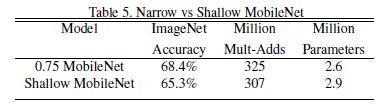  

__< Table 5 >__ 에서는 model의 layer를 얕게 쌓는 것보다 width Multiplier을 사용하여 thinner model을 사용하는 것이 더 낫다는 결과를 보여준다. Mult-Adds가 조금 많지만 정확도는 그것을 감수할정도로 더 높다.

## 4.2. Model Shirinking Hyperparameters

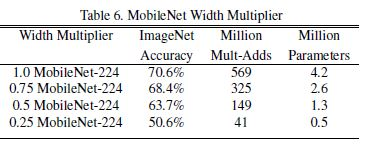  

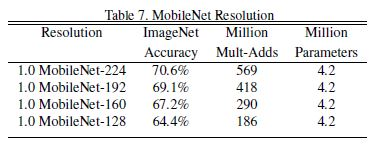  

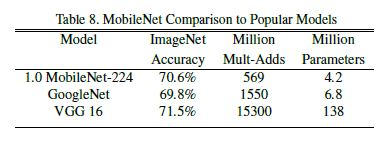  

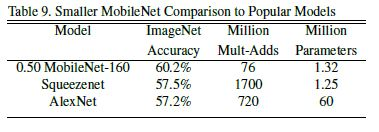  

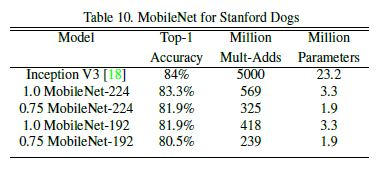  

위 table들은 MobileNet hyper parameter에 따른 비교, 다른 유명한 모델들과의 비교를 보여준다.